In [1]:
import os
import sys

os.chdir("..")
sys.path.append("..")

In [2]:
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository.datasets import get_dataset
from tqdm import tqdm

from src.app.utils import get_prediction_dataloader
from src.models.utils import get_model
from src.utils.evaluation import score_batch

/home/hakon/anaconda3/envs/whatif/lib/python3.7/site-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [3]:
def load_generated_data(value_prefix, feature_prefix, generated_test_datadir, len_test_data, ts_len):
    def filter_on_prefix(f, prefix, array):
        if f.startswith(prefix):
            file_name = f.split(".")[0]  # slice off .npy from file name
            ts_idx = int(file_name[len(prefix):])  # the remaining charachters after prefix is always the time series id
            array[ts_idx] = np.load(os.path.join(generated_test_datadir, f))

    raw_timeseries = [0 for _ in range(len_test_data)]
    features = [0 for _ in range(len_test_data)]
    for f in os.listdir(generated_test_datadir):
        filter_on_prefix(f, value_prefix, raw_timeseries)
        filter_on_prefix(f, feature_prefix, features)

    features = np.array(features)  # [len(original_test), num_manipulations, 4]
    return raw_timeseries, features

In [4]:
def create_dataloader(original_test, raw_timeseries, config):
    new_dataset = []
    for original_ts, manipulated_tss in zip(original_test, raw_timeseries):
        original_ts_start = original_ts["start"]
        original_ts_values = original_ts["target"]
        manipulated_ts_len = manipulated_tss.shape[1]

        start_index = pd.date_range(start=original_ts_start, freq=original_ts_start.freq, periods=len(original_ts_values))[-manipulated_ts_len]
        feat_static_cat = original_ts["feat_static_cat"]
        for manipulated_ts in manipulated_tss:
            new_entry = {"start": start_index, "target": manipulated_ts, "feat_static_cat": feat_static_cat}
            new_dataset.append(new_entry)

    new_dataset = ListDataset(new_dataset, freq=start_index.freq)
    return get_prediction_dataloader(new_dataset, config["context_length"], config["prediction_length"], batch_size=128)

In [5]:
def evaluate(model, dataloader, datadir, config):
    mape = []
    smape = []
    mase = []
    seasonal_mase = []
    mse = []
    model.eval()
    for batch in tqdm(dataloader):
        predictions = model.predict(batch)[:, :, 0]

        context = batch["past_target"].unsqueeze(dim=-1).numpy()
        target = batch["future_target"].numpy()
        scores = score_batch(target, predictions, context, config["sp"])

        mape.append(scores[0])
        smape.append(scores[1])
        mase.append(scores[2])
        seasonal_mase.append(scores[3])
        mse.append(scores[4])

    mape = np.vstack(mape)
    smape = np.vstack(smape)
    mase = np.vstack(mase)
    seasonal_mase = np.vstack(seasonal_mase)
    mse = np.vstack(mse)
    
    np.save(os.path.join(datadir, "mape.npy"), mape)
    np.save(os.path.join(datadir, "smape.npy"), smape)
    np.save(os.path.join(datadir, "mase.npy"), mase)
    np.save(os.path.join(datadir, "seasonal_mase.npy"), seasonal_mase)
    np.save(os.path.join(datadir, "mse.npy"), mse)

In [6]:
def load_modified_features_and_scores(model, experiment_dir, generated_test_datadir, config, original_test,
                                      value_prefix, feature_prefix, metric, redo_eval):
    raw_timeseries, features = load_generated_data(value_prefix, feature_prefix, generated_test_datadir,
                                                   len(original_test), config["context_length"] + config["prediction_length"])
    
    # if we have not haven't already predicted the manipulated data with the current model
    generated_model_scores_dir = os.path.join(experiment_dir, "generated_test", value_prefix[3:])
    if not os.path.exists(generated_model_scores_dir) or redo_eval:
        os.makedirs(generated_model_scores_dir, exist_ok=True)
        dataloader = create_dataloader(original_test, raw_timeseries, config)
        evaluate(model, dataloader, generated_model_scores_dir, config)

    # load selected metric
    scores = np.load(os.path.join(generated_model_scores_dir, f"{metric}.npy"))
    return features, scores

In [7]:
def load_original_features_and_scores(model, experiment_dir, datadir, config, original_test_data, metric, redo_eval):
    if redo_eval:
        dataloader = get_prediction_dataloader(original_test_data, config["context_length"], config["prediction_length"], batch_size=128)
        evaluate(model, dataloader, experiment_dir, config)
    
    features = np.load(os.path.join(datadir, "test_features.npy"))
    scores = np.load(os.path.join(experiment_dir, f"{metric}.npy"))
    return features, scores

In [8]:
def load_model_and_config(experiment_dir):
    with open(os.path.join(experiment_dir, "config.yaml"), "r") as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = get_model(config["model_name"])(**config["model_args"], device=device, path=config["path"])
    model.load_state_dict(torch.load(os.path.join(config["path"], "model.pth")))
    
    return model, config

In [9]:
def plot_feature_vs_score(features, scores, ax, title="", ylabel="", xlabel="", label=""):
    hist, bins = np.histogram(features, density=True, bins="auto")
    binned_scores = [[] for i in range(len(bins))]
    for feature_val, score in zip(features, scores):
        bin_num = np.where(feature_val >= bins)[0][-1]
        binned_scores[bin_num].append(score.mean(axis=-1))

    bin_means = np.array([np.nanmean(metric_bin) if len(metric_bin) > 0 else np.nan for metric_bin in binned_scores])
    nan_bins = np.isnan(bin_means)  # some bins might not 
    
    ax.plot(bins[~nan_bins], bin_means[~nan_bins], label=label, alpha=.75)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

In [10]:
def create_baseline_plot(dataset, model_names, datadir, original_test_data, metric, redo_eval):
    fig, axes = plt.subplots(1, 4, figsize=(20, 10), sharey="row")
    for model_name in model_names:
        experiment_dir = os.path.join("experiments", dataset, model_name)
        model, config = load_model_and_config(experiment_dir)
        features, scores = load_original_features_and_scores(model, experiment_dir, datadir, config, original_test_data, metric, redo_eval)

        # create plots
        feature_names = ["trend str", "trend slope", "trend lin", "seasonal str"]
        for i in range(4 if config["sp"] > 1 else 3):  # don't plot seasonal str if seasonality is not present in the data
            ax = axes[i]
            ylabel = metric if i == 0 else ""
            xlabel = feature_names[i]
            label = model_name if i == 0 else ""  # create a legend with the model names in the first subplot
            plot_feature_vs_score(features[:, i].flatten(), scores, ax, ylabel=ylabel, xlabel=xlabel, label=label)
    
    axes[0].legend()
    plt.suptitle(f"original {dataset}")

In [11]:
def create_modified_plot(dataset, model_names, datadir, generated_test_datadir, original_test, metric, redo_eval, plot_all=False):
    if plot_all:
        fig, ax_rows = plt.subplots(4, 4, figsize=(20, 20), sharey="row")
    else:
        fig, axes = plt.subplots(1, 4, figsize=(20, 10), sharey="row")

    for model_name in model_names:
        print(f"plotting {model_name}")
        experiment_dir = os.path.join("experiments", dataset, model_name)
        model, config = load_model_and_config(experiment_dir)

        value_feature_pairs = [("ts_trend_str", "feat_trend_str"), ("ts_trend_slope", "feat_trend_slope"),
                               ("ts_trend_lin", "feat_trend_lin"), ("ts_seasonal_str", "feat_seasonal_str")]
        for i, (value_prefix, feature_prefix) in enumerate(value_feature_pairs):
            # skip seasonal manipulations if seasonality is not present in the data set
            if config["sp"] == 1 and value_prefix == "ts_seasonal_str":
                continue

            features, scores = load_modified_features_and_scores(model, experiment_dir, generated_test_datadir, config, original_test, value_prefix, feature_prefix, metric, redo_eval)

            # create plots
            if plot_all:
                for j in range(4):
                    ax = ax_rows[i, j]
                    ylabel = f"{value_feature_pairs[i][0][3:]} manipulated\n{metric}" if j == 0 else ""  # plot the feature that was manipulated to create the data as the y label in the first column
                    xlabel = value_feature_pairs[j][0][3:] if i == 3 else ""  # plot the feature as the x label on the bottom row
                    label = model_name if i == 0 and j == 0 else ""  # create a legend with the model names in the first subplot
                    plot_feature_vs_score(features[:, :, j].flatten(), scores, ax, ylabel=ylabel, xlabel=xlabel, label=label)
            else:
                ax = axes[i]
                ylabel = metric if i == 0 else ""
                xlabel = value_feature_pairs[i][0][3:]
                label = model_name if i == 0 else ""  # create a legend with the model names in the first subplot
                plot_feature_vs_score(features[:, :, i].flatten(), scores, ax, ylabel=ylabel, xlabel=xlabel, label=label)
    
    if plot_all:
        ax_rows[0, 0].legend()
    else:
        axes[0].legend()
    plt.suptitle(f"modified {dataset}")

# Electricity

In [12]:
dataset = "electricity_nips"
model_names = ["feedforward", "nbeats_g", "nbeats_i", "seq2seq", "transformer", "tcn"]
metric = "smape"
datadir = os.path.join("data", dataset)
generated_test_datadir = os.path.join(datadir, "generated", "test")
original_test_data = get_dataset(dataset).test
redo_eval = False  # flag incase we want to evaluate again

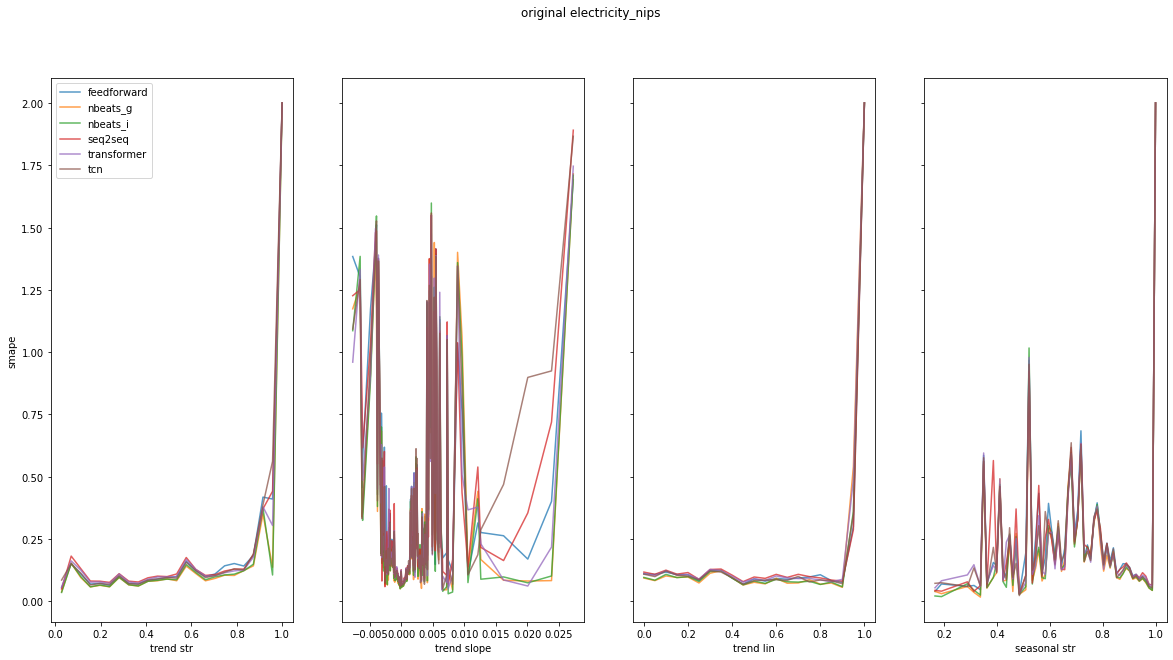

In [13]:
create_baseline_plot(dataset, model_names, datadir, original_test_data, metric, redo_eval)

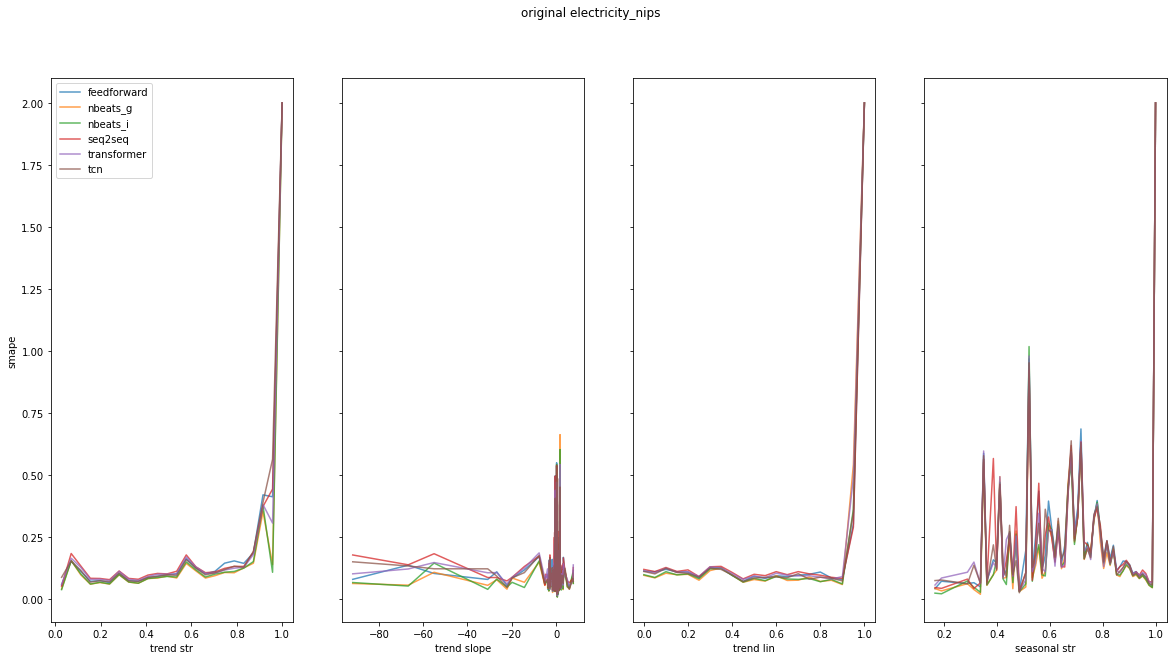

In [13]:
create_baseline_plot(dataset, model_names, datadir, original_test_data, metric, redo_eval)

plotting feedforward
plotting nbeats_g
plotting nbeats_i
plotting seq2seq
plotting transformer


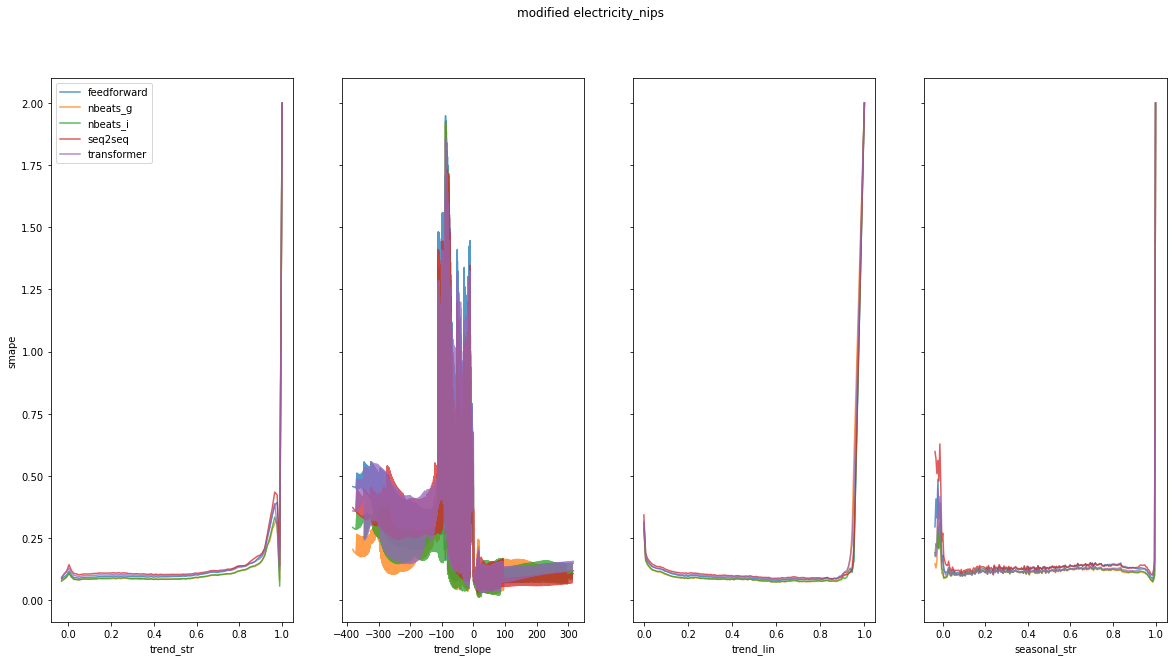

In [14]:
create_modified_plot(dataset, model_names[:-1], datadir, generated_test_datadir, original_test_data, metric, redo_eval)

# M4 weekly

In [15]:
dataset = "m4_weekly"
model_names = ["feedforward", "nbeats_g", "nbeats_i", "seq2seq", "transformer"]
datadir = os.path.join("data", dataset)
generated_test_datadir = os.path.join(datadir, "generated", "test")
original_test_data = get_dataset(dataset).test

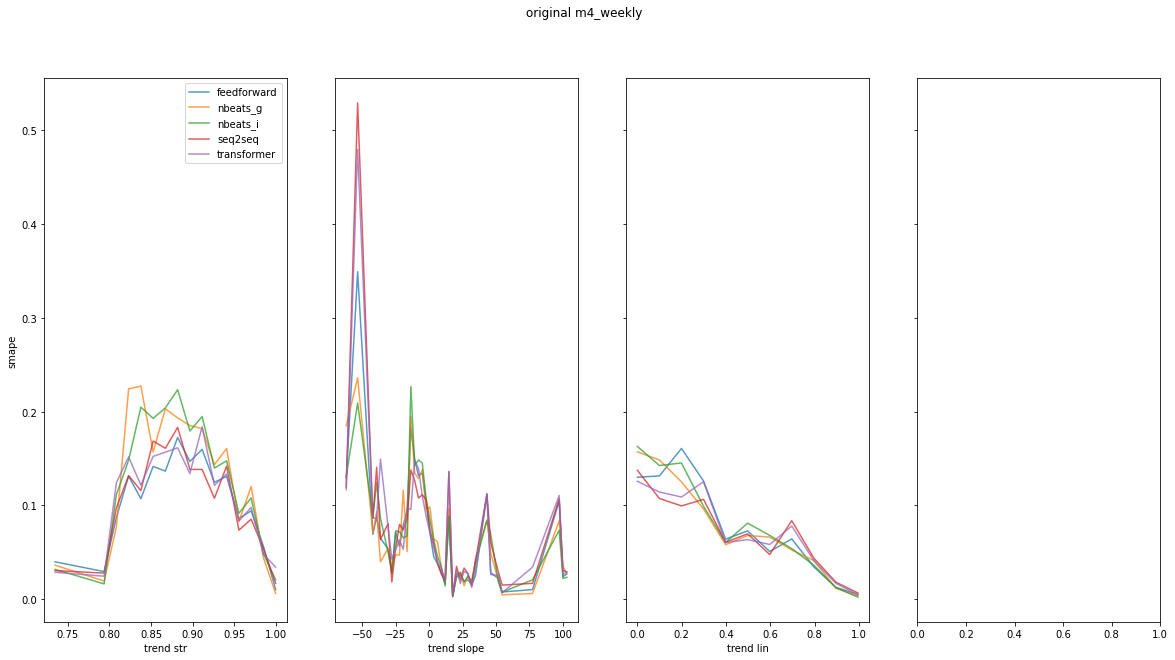

In [16]:
create_baseline_plot(dataset, model_names, datadir, original_test_data, metric, redo_eval)

plotting feedforward
plotting nbeats_g
plotting nbeats_i
plotting seq2seq
plotting transformer


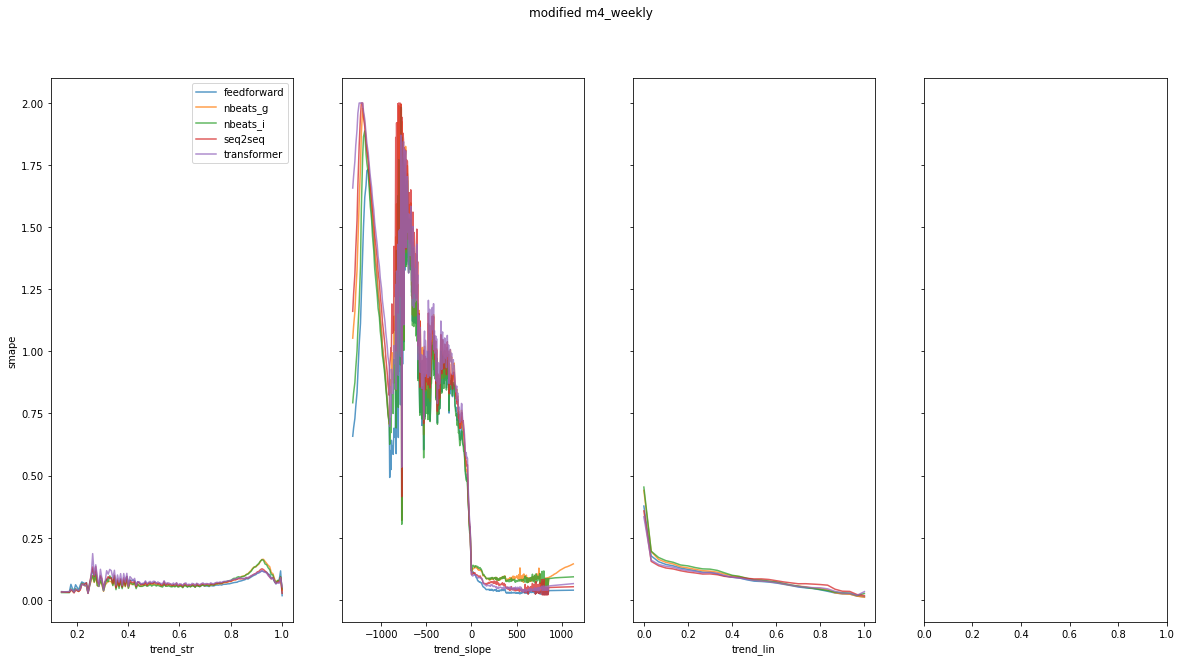

In [17]:
create_modified_plot(dataset, model_names, datadir, generated_test_datadir, original_test_data, metric, redo_eval)

# M4 daily

In [18]:
dataset = "m4_daily"
datadir = os.path.join("data", dataset)
generated_test_datadir = os.path.join(datadir, "generated", "test")
original_test_data = get_dataset(dataset).test

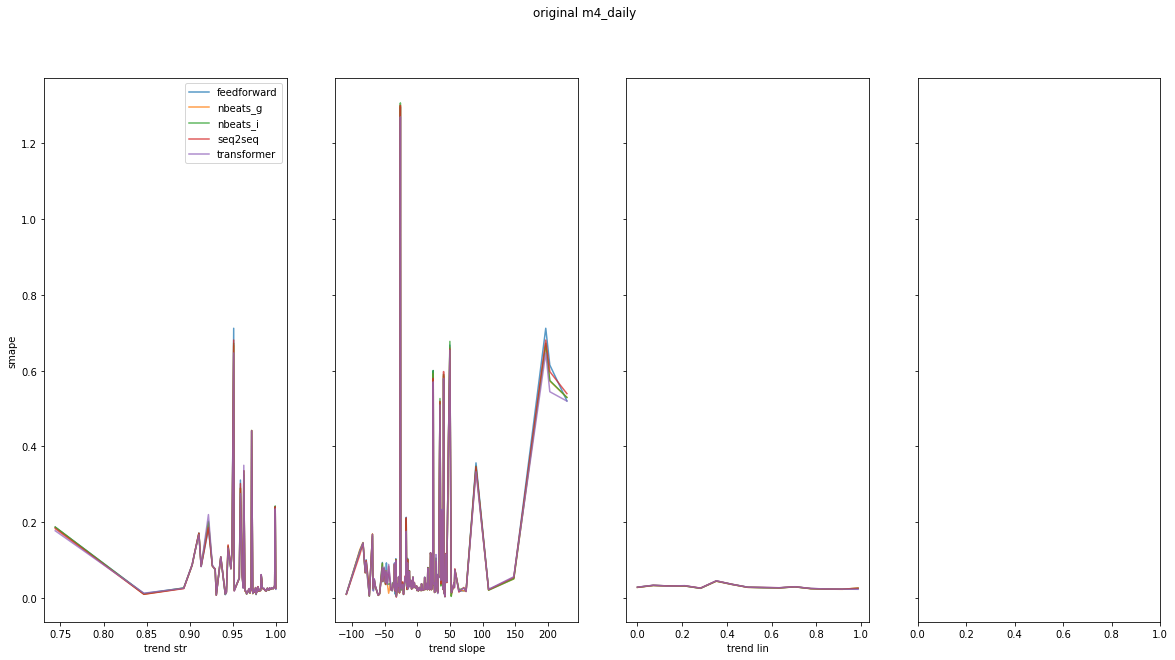

In [19]:
create_baseline_plot(dataset, model_names, datadir, original_test_data, metric, redo_eval)

plotting feedforward
plotting nbeats_g
plotting nbeats_i
plotting seq2seq
plotting transformer


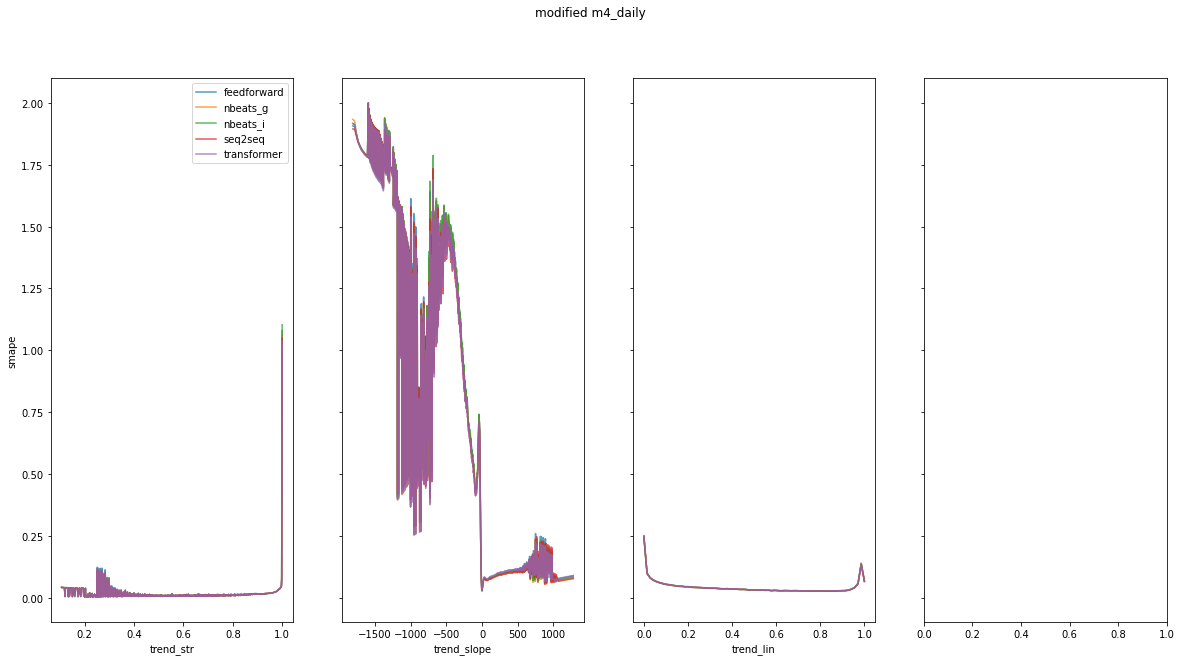

In [20]:
create_modified_plot(dataset, model_names, datadir, generated_test_datadir, original_test_data, metric, redo_eval)

# M4 hourly

In [21]:
dataset = "m4_hourly"
datadir = os.path.join("data", dataset)
generated_test_datadir = os.path.join(datadir, "generated", "test")
original_test_data = get_dataset(dataset).test

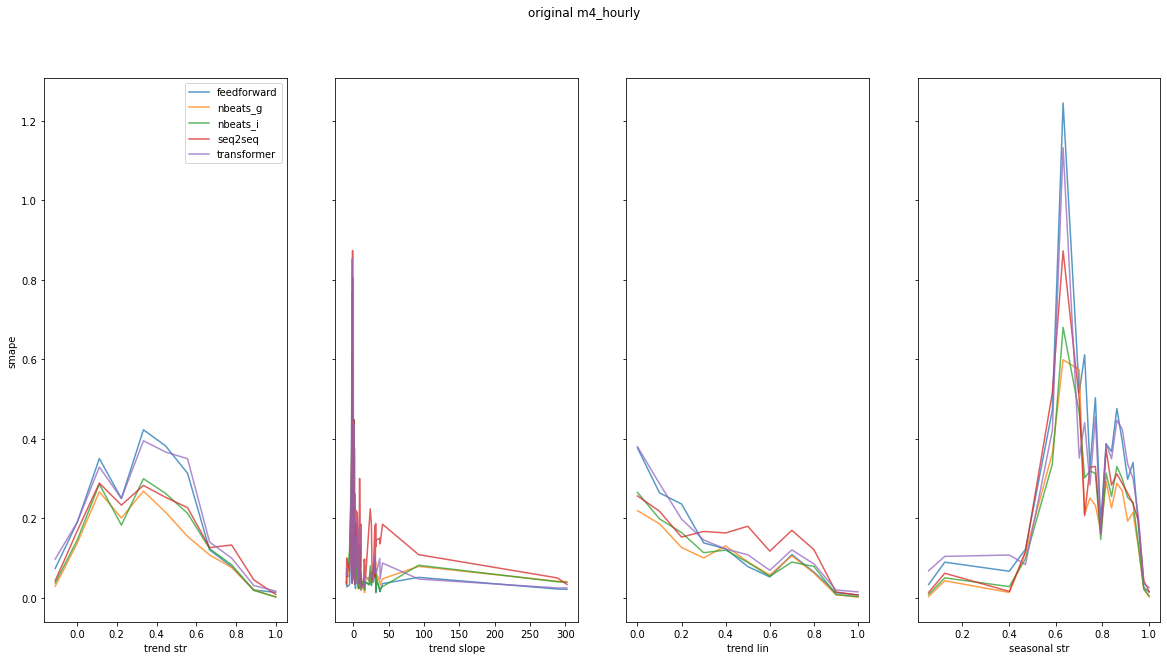

In [22]:
create_baseline_plot(dataset, model_names, datadir, original_test_data, metric, redo_eval)

plotting feedforward
plotting nbeats_g
plotting nbeats_i
plotting seq2seq
plotting transformer


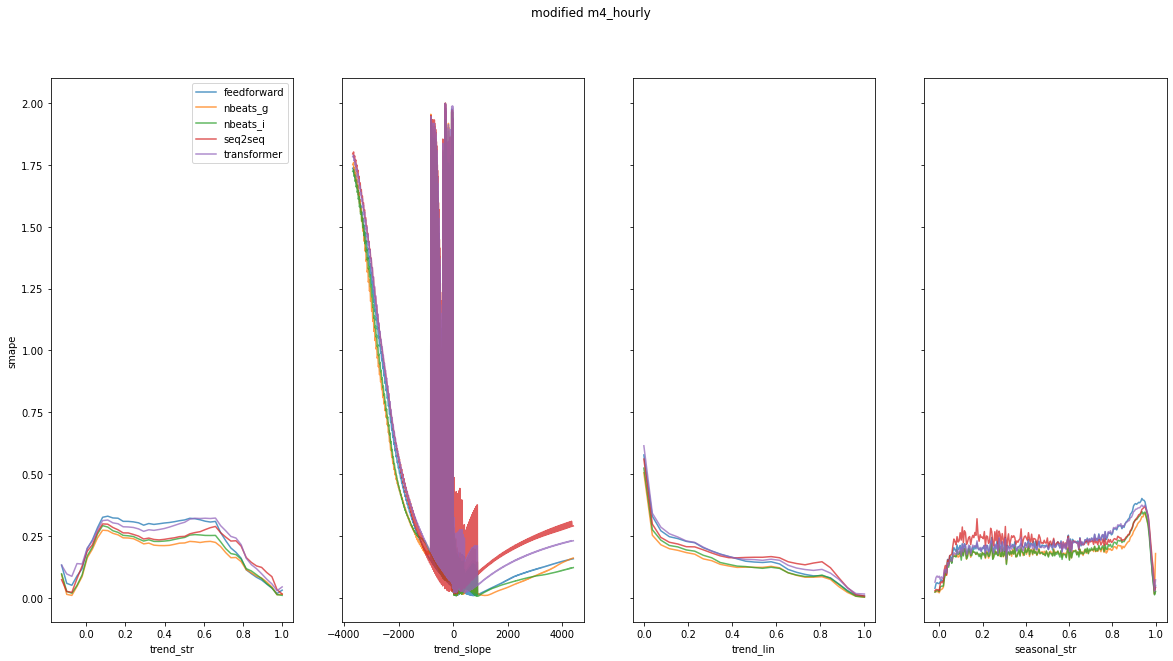

In [23]:
create_modified_plot(dataset, model_names, datadir, generated_test_datadir, original_test_data, metric, redo_eval)

# M4 yearly

In [24]:
dataset = "m4_yearly"
datadir = os.path.join("data", dataset)
generated_test_datadir = os.path.join(datadir, "generated", "test")
original_test_data = get_dataset(dataset).test

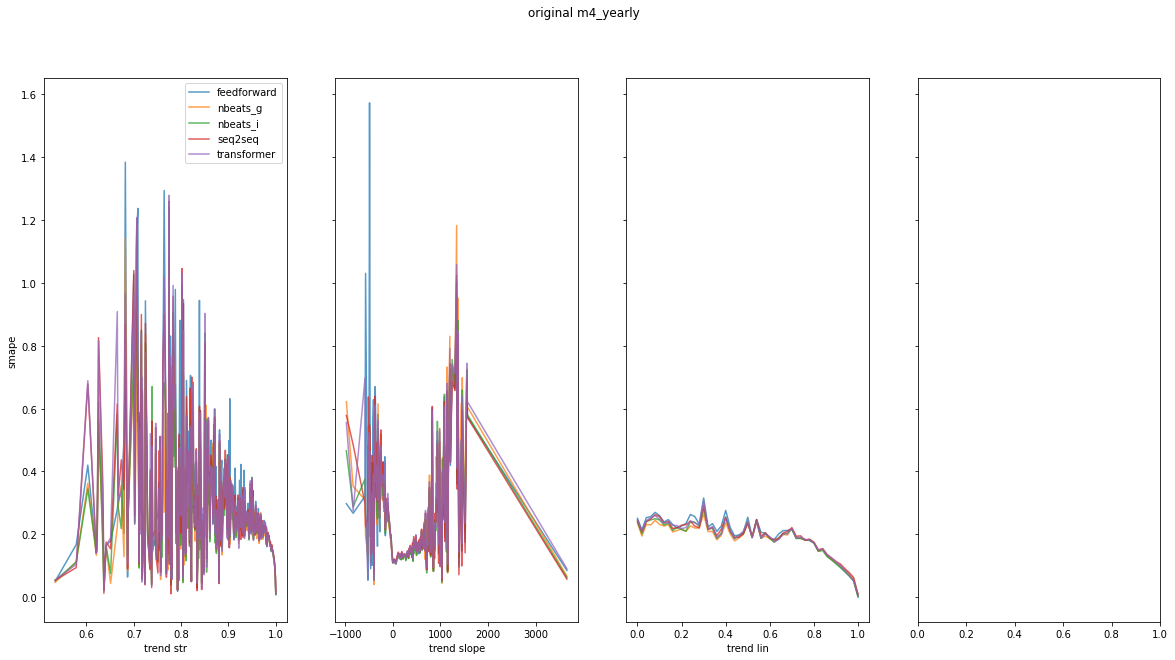

In [25]:
create_baseline_plot(dataset, model_names, datadir, original_test_data, metric, redo_eval)

In [26]:
#create_modified_plot(dataset, model_names, datadir, generated_test_datadir, original_test_data, metric, redo_eval)

# M4 quarterly

In [27]:
dataset = "m4_quarterly"
datadir = os.path.join("data", dataset)
generated_test_datadir = os.path.join(datadir, "generated", "test")
original_test_data = get_dataset(dataset).test

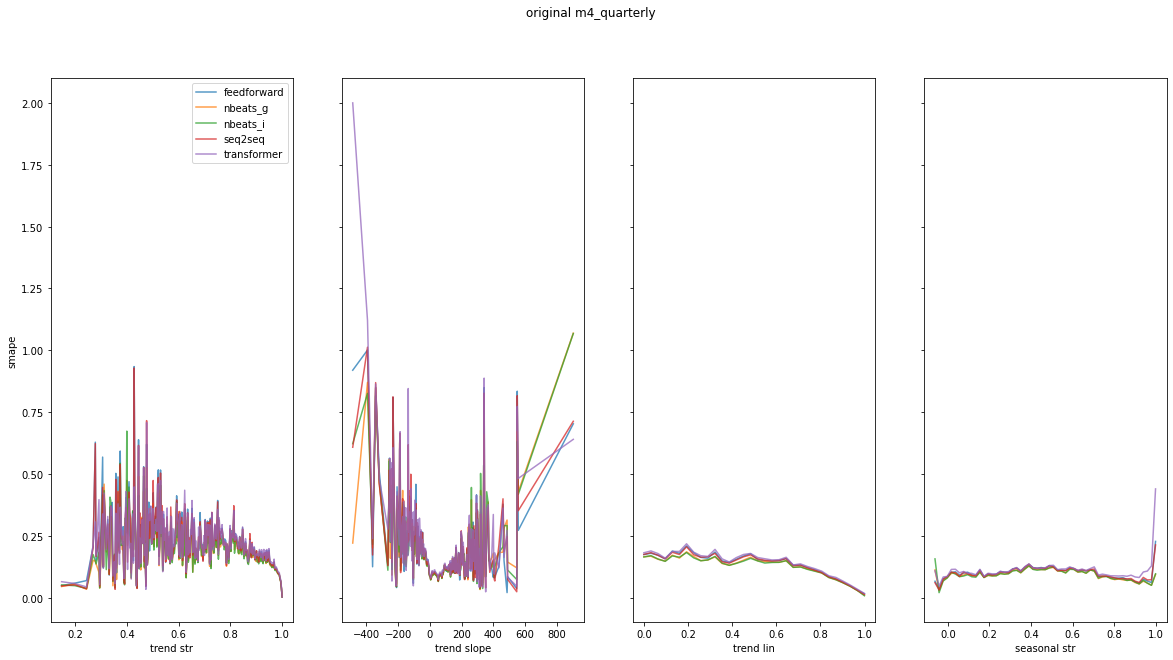

In [28]:
create_baseline_plot(dataset, model_names, datadir, original_test_data, metric, redo_eval)

In [29]:
#create_modified_plot(dataset, model_names, datadir, generated_test_datadir, original_test_data, metric, redo_eval)

# M4 monthly

In [30]:
dataset = "m4_monthly"
datadir = os.path.join("data", dataset)
generated_test_datadir = os.path.join(datadir, "generated", "test")
original_test_data = get_dataset(dataset).test

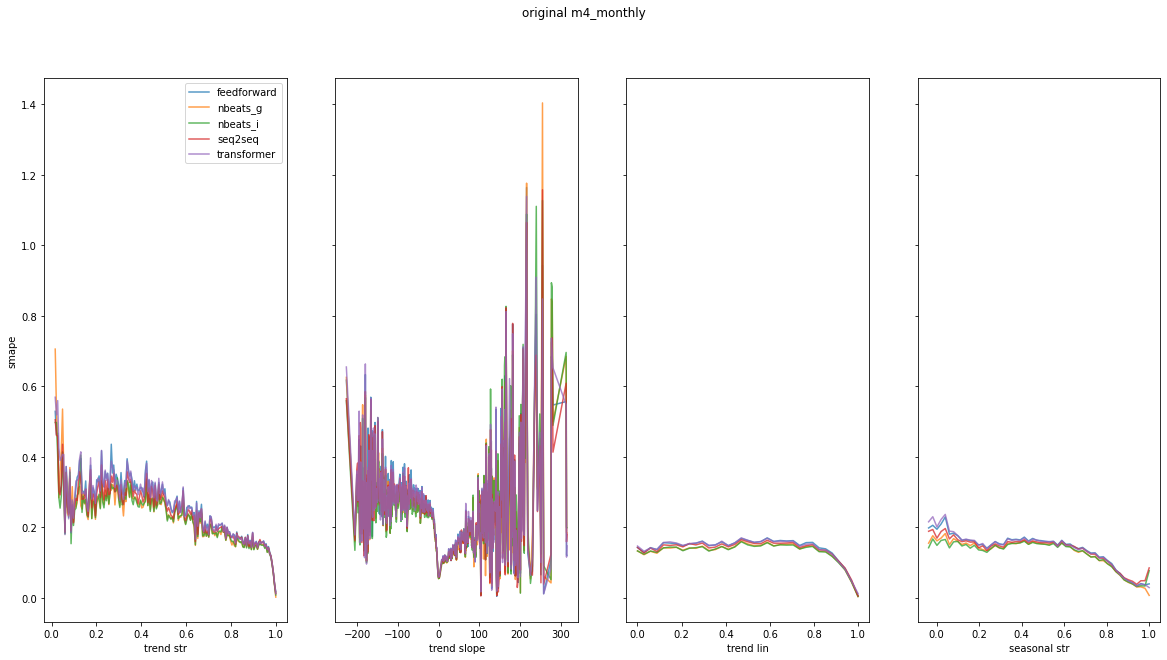

In [31]:
create_baseline_plot(dataset, model_names, datadir, original_test_data, metric, redo_eval)

In [32]:
#create_modified_plot(dataset, model_names, datadir, generated_test_datadir, original_test_data, metric, redo_eval)